In [41]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [42]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [43]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [44]:
from model_PyG import *
from utils import *

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [46]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [47]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [48]:
dataset = "mentos_05" # "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 16
	lr = 0.0001
	epochs = 100
elif (dataset == "vanessa_05"):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		"FrescoCusco_1", "FrescoCusco_2",
		"FrescoSanMartin_1", "FrescoSanMartin_2",
		"SecoAmazonas_1", "SecoAmazonas_2",
		"SecoCusco_1", "SecoCusco_2",
		"SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 150

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [49]:
transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

In [50]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["vanessa_05", "mentos_05"]: # Change
	for ts in train_set:
		df_edges = pd.read_csv("data/{}/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values, dtype=torch.long)
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float)

		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, intensity_mean, intensity_std, intensity_cv, presence_ratio, 0, 1, 2, ...
		x = torch.tensor(df_nodes.iloc[:, [2, 3, 4, 5, 6, 7]].values, dtype=torch.float) # Change
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)
		data = transform(data)
		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 1777
Num. edges:	 2134343
Num. features:	 6
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    0,    0,  ..., 1774, 1775, 1776],
        [   1,    2,    3,  ..., 1774, 1775, 1776]], device='cuda:0')
tensor([[ 1.8872e+00, -2.1626e+00,  5.1084e+00,  1.6168e-02,  3.1650e-03,
          1.0000e+00],
        [ 2.0378e+00, -2.1454e+00,  3.2162e+00,  3.4163e-01,  1.0622e-01,
          1.0000e+00],
        [ 1.7636e+00, -2.1379e+00,  4.2597e+00,  2.8798e-01,  6.7605e-02,
          1.0000e+00],
        ...,
        [ 1.9196e+00,  1.7690e+00,  4.4899e+00,  1.2438e-01,  2.7701e-02,
          1.0000e+00],
        [ 2.0216e+00,  1.7732e+00,  4.6991e+00,  6.2988e-02,  1.3404e-02,
          1.0000e+00],
        [ 2.3582e+00,  1.7774e+00,  3.5178e+00,  5.4619e-01,  1.5527e-01,
          1.0000e+00]], device='cuda:0')
tensor([ 0.5332, -0.9682, -0.6354,  ...,  1.0000,  1.0000,  1.0000],
       device='cud

In [51]:
train_loader

{'Red_1': Data(x=[1777, 6], edge_index=[2, 2134343], edge_weight=[2134343]),
 'Red_2': Data(x=[1772, 6], edge_index=[2, 2171236], edge_weight=[2171236])}

### Train

In [52]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [53]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-3 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]
			x = data.x
			edge_index = data.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			z = model(data.x, data.edge_index).detach()
			dict_node_embeddings[ts] = z.cpu().numpy()

	torch.cuda.empty_cache()

	return dict_node_embeddings, list_loss

In [54]:
train_set

['Red_1', 'Red_2']

In [55]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
mentos_05 0.0001 100 6 16 2


Epoch: 25:  24%|██▍       | 24/100 [01:43<05:27,  4.31s/it, Loss: 0.6277]


Stopping early as no improvement has been observed.
Early stopping at epoch 25


### Get embeddings

In [56]:
dict_node_embeddings

{'Red_1': array([[ 0.46047178, -0.33620703,  0.27250546, ...,  0.24365912,
          0.02850342,  0.20505401],
        [ 0.48069468, -0.28185835,  0.37286234, ...,  0.24148041,
          0.07201588,  0.2289993 ],
        [ 0.46192765, -0.31215054,  0.31198257, ...,  0.23200136,
          0.04986501,  0.19945402],
        ...,
        [ 0.28159103, -0.518973  ,  0.28673136, ...,  0.11905281,
          0.07707664,  0.1038807 ],
        [ 0.2851509 , -0.5246348 ,  0.27717975, ...,  0.12530047,
          0.07324994,  0.10967778],
        [ 0.3135315 , -0.478176  ,  0.33416787, ...,  0.13702911,
          0.12294656,  0.14508554]], dtype=float32),
 'Red_2': array([[ 0.4448463 , -0.3186812 ,  0.2916662 , ...,  0.24109401,
          0.03124131,  0.216523  ],
        [ 0.44037884, -0.3238299 ,  0.25615406, ...,  0.23157239,
          0.03833499,  0.19245017],
        [ 0.45272982, -0.3033567 ,  0.31429946, ...,  0.24610314,
          0.04642674,  0.23218112],
        ...,
        [ 0.28248063,

### Plot

In [57]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(3549, 16)


array([[ 0.46047178, -0.33620703,  0.27250546, ...,  0.24365912,
         0.02850342,  0.20505401],
       [ 0.48069468, -0.28185835,  0.37286234, ...,  0.24148041,
         0.07201588,  0.2289993 ],
       [ 0.46192765, -0.31215054,  0.31198257, ...,  0.23200136,
         0.04986501,  0.19945402],
       ...,
       [ 0.28248063, -0.4982226 ,  0.29601425, ...,  0.14197853,
         0.08028065,  0.15125576],
       [ 0.25892067, -0.5194527 ,  0.2613287 , ...,  0.11818935,
         0.06641842,  0.10593161],
       [ 0.2671991 , -0.5206499 ,  0.2574609 , ...,  0.12944028,
         0.07174312,  0.12290834]], dtype=float32)

In [58]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
    labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

3549
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [59]:
list_loss

[0.6322032809257507,
 10.806614875793457,
 1.0595523118972778,
 0.886027455329895,
 1.7692086696624756,
 0.7905691266059875,
 0.6792375445365906,
 0.6287487745285034,
 0.9018216133117676,
 0.6373738050460815,
 0.6268357038497925,
 0.6599906086921692,
 0.629489541053772,
 0.6268993020057678,
 0.6251364946365356,
 0.6385993957519531,
 0.6341683864593506,
 0.6256844997406006,
 0.6269623041152954,
 0.6248619556427002,
 0.629672646522522,
 0.6247600317001343,
 0.6272682547569275,
 0.6250914931297302,
 0.6277308464050293]

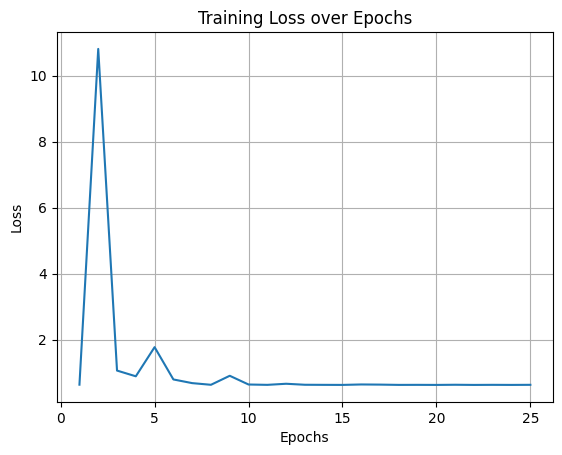

In [60]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

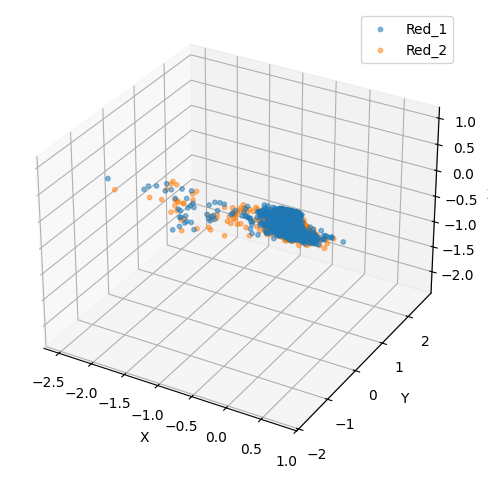

In [61]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

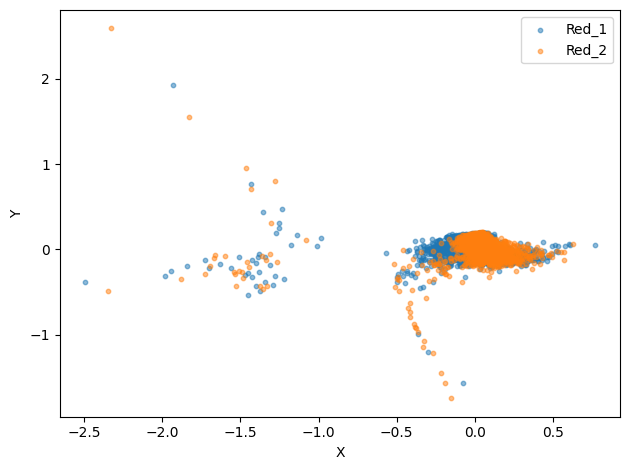

In [62]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()

### Similarity analysis (KNN)

In [63]:
train_set

['Red_1', 'Red_2']

In [64]:
# Get node ids

dict_node_id = {}

if dataset in ["vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
    for ts in train_set:
        dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'Red_1': array([  13,   24,   33, ..., 2301, 2304, 2306]),
 'Red_2': array([  13,   14,   24, ..., 2185, 2225, 2277])}

In [65]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	
	df_node_alignment[ts] = dict_node_id[ts][indices]
df_node_alignment

,Red_1,Red_2
0,13,150
1,24,494
2,33,24
3,40,102
4,50,24
...,...,...
1772,2285,2274
1773,2295,2273
1774,2301,2204
1775,2304,2228


In [66]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

Red_1 Red_2


,Red_1,Red_2
6,69,69
7,70,70
18,132,132
20,140,140
25,156,156
...,...,...
1683,1897,1897
1698,1946,1946
1718,2059,2059
1742,2176,2176


In [67]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

77


,Red_1,Red_2
6,69,69
7,70,70
18,132,132
20,140,140
25,156,156
...,...,...
1683,1897,1897
1698,1946,1946
1718,2059,2059
1742,2176,2176


In [68]:
# Comparison (with test_pairs)

if dataset not in ["vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [69]:
common_node_id = df_node_alignment_filter.iloc[:, 1].values
common_node_id

array([  69,   70,  132,  140,  156,  265,  279,  375,  418,  449,  455,
        521,  551,  556,  567,  612,  664,  706,  743,  747,  766,  771,
        807,  808,  823,  851,  878,  884,  926,  943, 1003, 1032, 1062,
       1162, 1246, 1347, 1411, 1462, 1597, 1668, 1759, 1765, 1772, 1779,
       1891, 1906, 1926, 1984, 1991, 1999, 2094, 2103, 2164, 2214, 2270,
        119,  248,  251,  311,  346,  420,  462,  500,  643,  676,  780,
        825, 1022, 1278, 1753, 1791, 1792, 1897, 1946, 2059, 2176, 2278])

In [70]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [71]:
print(len(common_node_id), len(df_join_raw))

77 1782


In [72]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
69,1.429,300.12060,Unknown
70,1.438,463.54140,Unknown
132,2.263,70.06041,Unknown
140,2.493,59.18501,Unknown
156,2.794,60.02826,Unknown
...,...,...,...
1897,28.469,121.10720,Unknown
1946,29.129,280.96000,Unknown
2059,30.656,183.16340,Unknown
2176,32.468,55.05905,Unknown


In [73]:
# Comparison (sta vs Van)

list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)

['Red_1', 'Red_2']
Alignment: 77 / 1782
Match comp: 1/23
{70}


### Clustering analysis

In [74]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,...,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3,Blank_1.1,Blank_2.1
4,0.767,353.94570,Unknown,8.253400e-01,9.200000e-06,0.000009,9.200000e-06,9.200000e-06,9.200000e-06,0.000009,...,0.000009,9.200000e-06,0.000009,9.200000e-05,0.000009,6.888500e-01,0.000009,9.200000e-06,14499.11,2.265930e+04
13,0.849,77.12775,Unknown,1.387898e+05,8.624046e+04,72342.450000,1.051718e+05,1.057505e+05,9.259037e+04,117097.500000,...,82741.240000,7.053877e+04,207908.600000,1.581832e+05,120187.200000,9.076510e+04,89014.010000,1.132883e+05,238760.10,9.052885e+04
14,0.862,45.97014,Unknown,6.765457e+04,8.858592e+04,62918.100000,6.450759e+04,9.565974e+04,3.624424e+05,55364.950000,...,171163.700000,4.818176e+05,108095.600000,1.362666e+04,14977.210000,8.767414e+04,124921.300000,1.537605e+04,139203.70,1.000444e+05
24,0.992,109.10390,Unknown,2.234586e+04,2.257770e+04,25630.570000,6.198678e+04,2.216297e+04,3.976091e+04,48250.450000,...,29739.320000,2.090890e+04,10700.320000,4.117690e+03,5520.715000,2.248320e+04,29960.300000,2.081087e+05,106600.00,2.502775e+04
28,1.007,132.12760,Unknown,2.393976e+01,5.186566e+04,3109.359000,6.929501e+03,8.732821e+03,6.296857e+03,21127.380000,...,11475.910000,1.632536e+04,1187.276000,6.521130e+03,3848.260000,2.607996e+04,13962.350000,2.855882e+04,57370.48,3.279362e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,33.631,83.09895,Unknown,2.610749e+05,3.069017e+05,215637.400000,1.398896e+05,1.307836e+05,1.752427e+05,191386.700000,...,299743.400000,2.274897e+05,14049.380000,4.142575e+04,36417.310000,9.815955e+04,161472.700000,2.311965e+05,1397670.00,1.789797e+05
2303,33.653,457.39230,Unknown,1.000000e-07,1.000000e-07,0.000004,1.000000e-07,1.000000e-07,1.000000e-07,0.000001,...,5477.928000,1.000000e-07,17335.640000,1.000000e-07,3668.895000,1.000000e-07,1243.702000,1.000000e-07,51166.44,1.000000e-07
2304,33.666,105.09980,Unknown,4.961273e+04,9.736624e+04,109105.300000,1.165776e+05,1.079196e+05,9.511641e+04,141866.500000,...,139319.000000,1.264424e+05,81152.250000,1.082530e+05,99531.660000,1.189775e+05,198119.500000,1.690732e+05,631228.90,1.729256e+05
2305,33.673,93.09473,Unknown,1.337628e+05,1.239729e+05,91317.910000,9.673636e+04,9.306306e+04,1.107218e+05,122202.900000,...,99013.660000,7.839004e+04,59013.780000,1.218907e+05,142875.100000,2.201098e+05,217304.100000,1.155046e+05,1107215.00,5.177241e+04


In [75]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:-2] # Important two last column no only to Mentos
df_join_raw_signal

,Blank_2.2,Blank_2.3,Blank_2.4,Blank_2.5,Blank_2.6,Blank_2.7,Blank_2.8,Blank_2.9,Blank_2.10,QC_1.1,...,Red_1.3,Red_2.1,Red_2.2,Red_2.3,Orange_1.1,Orange_1.2,Orange_1.3,Orange_2.1,Orange_2.2,Orange_2.3
69,2.000000e-07,2.600824e+02,2.115175e+03,9.086964e+03,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,2.800000e-05,...,3.264616e+02,1.376335e+04,2.000000e-07,2.000000e-07,2.000000e-07,1.182456e+04,1.549738e+04,2.000000e-07,2.000000e-07,2.000000e-07
70,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06,...,4.300000e-06,4.300000e-06,4.300000e-06,1.762100e-01,1.109668e+04,4.929900e-01,4.300000e-06,4.300000e-06,4.300000e-06,4.300000e-06
132,4.346151e+04,9.383098e+04,6.227550e+04,6.575279e+04,4.222636e+04,5.988725e+04,6.417058e+04,8.629180e+04,3.042639e+05,2.354179e+05,...,3.265040e+07,1.258051e+07,1.123084e+07,1.282572e+07,1.670467e+05,1.356173e+05,1.679138e+05,1.060207e+05,7.017214e+04,2.241680e+05
140,9.362630e+04,5.649736e+04,6.960310e+04,4.158213e+04,2.187184e+04,1.321207e+06,9.595070e+04,3.407458e+04,2.721429e+04,6.316204e+05,...,3.669693e+05,4.340247e+05,1.009497e+06,2.333727e+05,1.029543e+06,3.663880e+05,4.234979e+05,5.226777e+05,7.439218e+05,1.282380e+05
156,4.475703e+05,3.868560e+05,7.484058e+05,3.475323e+05,3.953081e+05,4.903940e+05,4.775330e+05,9.933225e+04,6.609656e+05,2.815094e+06,...,1.615851e+06,3.327235e+06,1.735686e+06,1.384997e+06,2.965676e+06,2.360368e+06,3.160501e+06,1.294973e+06,1.234736e+06,3.892898e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,8.255698e+04,9.769584e+04,1.007050e+05,1.199267e+05,9.387130e+04,4.619496e+04,4.794586e+04,5.247104e+04,8.573058e+04,9.282206e+04,...,9.159726e+04,1.045381e+05,8.691419e+04,1.145082e+05,1.661176e+05,8.261909e+04,1.636061e+05,1.373513e+05,1.311790e+05,3.750736e+04
1946,4.424462e+05,3.235345e+05,4.540433e+05,2.460909e+05,4.062855e+05,3.673352e+05,4.061009e+05,2.157408e+05,2.600507e+05,3.597419e+05,...,4.184779e+05,4.506779e+05,3.053187e+05,4.108939e+05,3.653783e+05,3.776753e+05,3.369447e+05,3.503538e+05,3.005773e+05,3.629928e+05
2059,5.162479e+04,5.684573e+04,3.406825e+04,4.599041e+04,4.534239e+04,3.304717e+04,5.606897e+04,4.792539e+04,1.752860e+02,6.632415e+04,...,3.383546e+04,3.997705e+04,4.102050e+04,4.284905e+04,1.772327e+05,3.015683e+05,4.406979e+04,1.887388e+04,3.997655e+04,6.607123e+04
2176,2.293219e+05,1.713188e+05,2.516583e+05,1.279378e+05,1.654729e+05,1.438548e+05,1.921285e+05,9.291612e+04,1.760206e+05,2.092523e+05,...,2.838023e+05,2.257491e+05,2.814165e+05,1.960052e+05,2.819019e+05,4.309830e+05,2.761526e+05,2.090116e+05,1.642813e+05,1.809805e+05


In [76]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,69,70,132,140,156,265,279,375,418,449,...,1022,1278,1753,1791,1792,1897,1946,2059,2176,2278
Blank_2.2,2.000000e-07,0.000004,43461.51,93626.30,447570.30,28526.85,3.200000e-05,93944.15,29734.59,36246.57,...,1.000000e-07,202585.70,148472.50,135812.30,283821.6,82556.98,442446.2,51624.790,229321.90,4.420000e-15
Blank_2.3,2.600824e+02,0.000004,93830.98,56497.36,386856.00,64770.84,1.197027e+01,296164.80,101603.60,50884.44,...,7.675300e-01,160145.90,114733.80,86296.38,240132.2,97695.84,323534.5,56845.730,171318.80,4.420000e-15
Blank_2.4,2.115175e+03,0.000004,62275.50,69603.10,748405.80,25600.75,1.000000e-07,113345.70,58921.85,29859.30,...,1.000000e-07,88584.13,123929.40,137953.30,241424.4,100705.00,454043.3,34068.250,251658.30,2.340000e-12
Blank_2.5,9.086964e+03,0.000004,65752.79,41582.13,347532.30,32988.10,1.000000e-07,4362042.00,56042.37,43206.91,...,1.348673e+01,125652.00,104640.90,74812.41,205247.3,119926.70,246090.9,45990.410,127937.80,4.420000e-15
Blank_2.6,2.000000e-07,0.000004,42226.36,21871.84,395308.10,21145.83,2.426342e+04,107799.40,54183.58,111328.50,...,1.000000e-07,143097.10,107989.80,57675.38,232623.8,93871.30,406285.5,45342.390,165472.90,4.420000e-15
Blank_2.7,2.000000e-07,0.000004,59887.25,1321207.00,490394.00,27055.20,1.000000e-07,4095511.00,45313.75,52183.41,...,1.000000e-07,165235.20,125795.20,83549.73,188082.0,46194.96,367335.2,33047.170,143854.80,5.328576e+02
Blank_2.8,2.000000e-07,0.000004,64170.58,95950.70,477533.00,42774.95,1.243900e-01,151921.80,33046.50,65966.19,...,1.000000e-07,145072.10,63725.02,79806.63,179667.9,47945.86,406100.9,56068.970,192128.50,3.490000e-06
Blank_2.9,2.000000e-07,0.000004,86291.80,34074.58,99332.25,1536772.00,1.000000e-07,558289.60,61571.28,118148.00,...,1.000000e-07,97585.11,30709.29,129193.90,145183.1,52471.04,215740.8,47925.390,92916.12,4.420000e-15
Blank_2.10,2.000000e-07,0.000004,304263.90,27214.29,660965.60,400633.50,1.000000e-07,330754.10,14878.16,34177.49,...,1.000000e-07,63448.34,25454.07,220633.60,140767.5,85730.58,260050.7,175.286,176020.60,4.420000e-15
QC_1.1,2.800000e-05,0.000004,235417.90,631620.40,2815094.00,1265011.00,1.000000e-07,450479.90,108369.50,200277.40,...,2.196539e+04,204455.30,123722.00,148571.90,207512.8,92822.06,359741.9,66324.150,209252.30,5.000000e-05


In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[-0.46470624, -0.17154048, -0.46657521, ..., -0.25619324,
        -0.04825886, -0.17154002],
       [-0.40232527, -0.17154048, -0.46142109, ..., -0.15615114,
        -0.74722884, -0.17154002],
       [ 0.04262018, -0.17154048, -0.46465004, ..., -0.59260643,
         0.22090732, -0.17154002],
       ...,
       [-0.46470624, -0.17154048, -0.46017376, ..., -0.88375643,
        -0.2930094 , -0.17154002],
       [-0.46470624, -0.17154048, -0.46384201, ..., -0.47939335,
        -0.83203467, -0.17154002],
       [-0.46470624, -0.17154048, -0.4480842 , ...,  0.02062514,
        -0.63079992, -0.17154002]])

In [78]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-7.35341573e-01, -1.95733654e+00],
       [-2.35153028e+00, -1.32644972e+00],
       [-2.21075166e+00, -1.50392464e+00],
       [-3.27980148e+00, -1.82661537e+00],
       [-3.45911954e+00, -1.39328650e+00],
       [-3.82652690e+00, -3.13111514e-01],
       [-2.51690242e+00, -2.21210869e+00],
       [-4.54171177e+00, -1.37056484e+00],
       [-3.78408326e+00, -3.09281050e+00],
       [ 3.72939055e-01,  1.98403783e+00],
       [-2.99501148e-03,  1.23299127e+00],
       [ 1.07764407e+00,  2.23585788e+00],
       [-3.43835684e-01,  6.88070479e-01],
       [-2.31813619e-01,  1.67346793e+00],
       [ 2.20393978e-01,  1.16244308e+00],
       [-5.47026893e-02,  1.41435830e+00],
       [-4.26280098e+00, -5.34272866e-01],
       [ 3.16538503e+00, -2.40351206e+00],
       [ 4.14332309e+00, -4.00108061e+00],
       [ 1.24086643e+01, -8.44956505e+00],
       [ 3.15325499e-01, -1.46497698e+00],
       [-1.53254715e+00, -8.46856307e-01],
       [-2.23264639e+00, -4.27395480e-01],
       [-1.

In [79]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'Blank',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'QC',
 'Std',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Yellow',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange',
 'Orange']

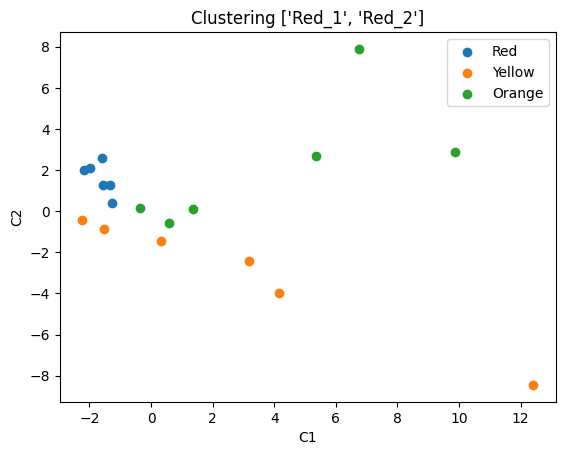

In [80]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = ["Red", "Yellow", "Orange"] # np.unique(labels)

for group in unique_groups:
    xi = [x[i] for i in range(len(x)) if labels[i] == group]
    yi = [y[i] for i in range(len(y)) if labels[i] == group]
    plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()